In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

In [2]:
mnist # one row per sample, one col per feature

{'data': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'target': array(['5', '0', '4', ..., '4', '5', '6'], dtype=object),
 'frame': None,
 'categories': {},
 'feature_names': ['pixel1',
  'pixel2',
  'pixel3',
  'pixel4',
  'pixel5',
  'pixel6',
  'pixel7',
  'pixel8',
  'pixel9',
  'pixel10',
  'pixel11',
  'pixel12',
  'pixel13',
  'pixel14',
  'pixel15',
  'pixel16',
  'pixel17',
  'pixel18',
  'pixel19',
  'pixel20',
  'pixel21',
  'pixel22',
  'pixel23',
  'pixel24',
  'pixel25',
  'pixel26',
  'pixel27',
  'pixel28',
  'pixel29',
  'pixel30',
  'pixel31',
  'pixel32',
  'pixel33',
  'pixel34',
  'pixel35',
  'pixel36',
  'pixel37',
  'pixel38',
  'pixel39',
  'pixel40',
  'pixel41',
  'pixel42',
  'pixel43',
  'pixel44',
  'pixel45',
  'pixel46',
  'pixel47',
  'pixel48',
  'pixe

In [3]:
X = mnist['data']
y = mnist['target']
print(X.shape) # 28x28 = 784
print(y.shape)

(70000, 784)
(70000,)


In [4]:
# split train, test
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [5]:
import numpy as np

# shuffle
shuffle_idx = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_idx], y_train[shuffle_idx]

(-0.5, 27.5, 27.5, -0.5)

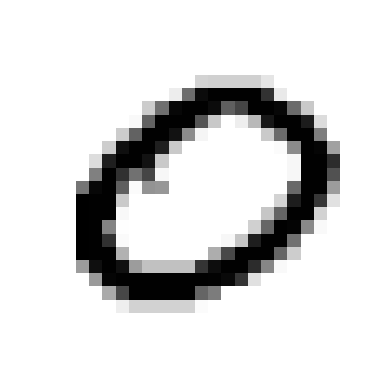

In [6]:
import matplotlib.pyplot as plt

# plot sample image

plt.imshow(X_train[15].reshape(28, 28), cmap=plt.get_cmap('binary'), interpolation='nearest')
plt.axis('off')

# Training binary classifier: Stochastic Gradient Descent

In [7]:
from sklearn.linear_model import SGDClassifier

sgd_bin = SGDClassifier(random_state=42) # depends on random, as it is stochastic
sgd_bin.fit(X_train, (y_train == '5')) # detect all 1

SGDClassifier(random_state=42)

In [8]:
sgd_bin.predict([X_train[15]])

array([False])

In [9]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_bin, X_train, (y_train == '5'), cv=3, scoring="accuracy")

array([0.95075, 0.9661 , 0.9665 ])

In [10]:
# stratified sampling via own implementation of cross validation

from sklearn.model_selection import StratifiedKFold # stratified sampling based on label
from sklearn.base import clone # creates unfitted estimator with same hyperparams
from sklearn.metrics import accuracy_score

skfolds = StratifiedKFold(n_splits=3)

y_train_5 = (y_train=='5')

for train_idx, test_idx in skfolds.split(X_train, y_train_5):
    clone_sgd = clone(sgd_bin)
    clone_sgd.fit(X_train[train_idx], y_train_5[train_idx])
    y_pred = clone_sgd.predict(X_train[test_idx])
    acc = accuracy_score(y_pred=y_pred, y_true=y_train_5[test_idx])
    print(acc)

0.95075
0.9661
0.9665


## Metrics

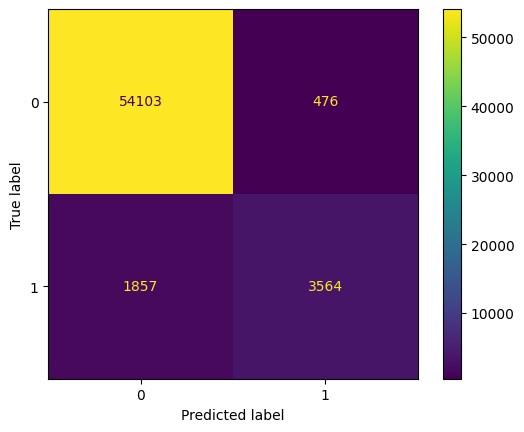

In [11]:
from sklearn.model_selection import cross_val_predict # cross validation and "clean" prediction on each test set
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_cross_preds = cross_val_predict(sgd_bin, X_train, y_train_5, cv=3)
cm = confusion_matrix(y_pred=y_cross_preds, y_true=y_train_5)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [12]:
precision = cm[1, 1] / (cm[0, 1] + cm[1, 1]) # TP / (TP + FP)
precision # 100% if we only predict one sample as TP

0.8821782178217822

In [13]:
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0]) # recall, sensitivity, true positive rate
recall

0.6574432761483121

In [14]:
# f1: harmonic mean of recall and precision -> gives more weight to low values
f1 = 2/ ((1/recall) + (1/precision))
f1 = 2* (precision*recall)/(precision + recall)
f1

0.753408730578163

In [15]:
from sklearn.metrics import f1_score

f1_score(y_cross_preds, y_train_5)

0.753408730578163

### Precision-Recall-Tradeoff

In [16]:
y_scores = sgd_bin.decision_function([X_train[0]])
y_scores # get score for SGD if > 0 -> True else False

array([-4554.71512942])

In [17]:
y_scores = cross_val_predict(sgd_bin, X_train, y_train_5, cv=3,
                             method="decision_function") # return scoring instead of predicted label

In [18]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

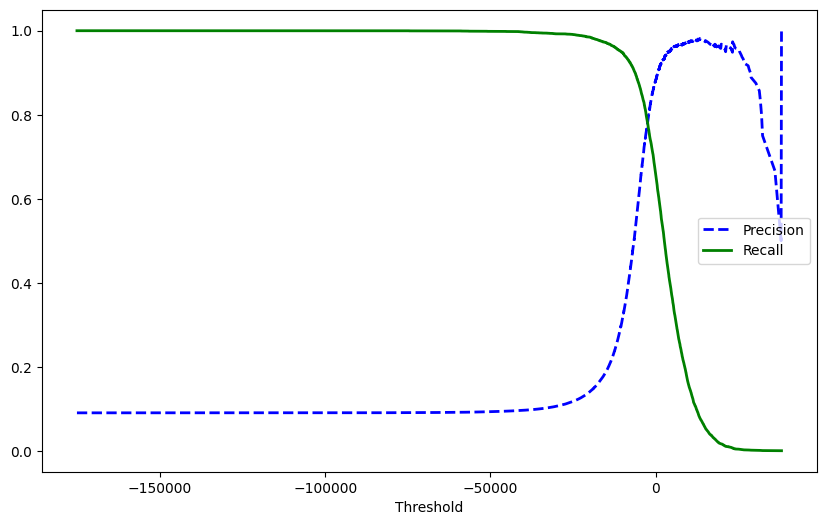

In [19]:
plt.figure(figsize=(10, 6))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.xlabel("Threshold")
plt.legend(loc="center right")
# note that precision may go down when threshold increases

In [20]:
# find threshold for precision > 90%
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

646.4577394625278

In [21]:
from sklearn.metrics import precision_score, recall_score

y_train_pred_90 = (y_scores >= threshold_for_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000537345513165

In [22]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.6179671647297547

### ROC Curve
Plotting of TPR vs. FPR.


Tradeoff between TPR and FPR. The more true positives, the more false positives.

In [23]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Text(0, 0.5, 'True Positive Rate (Recall)')

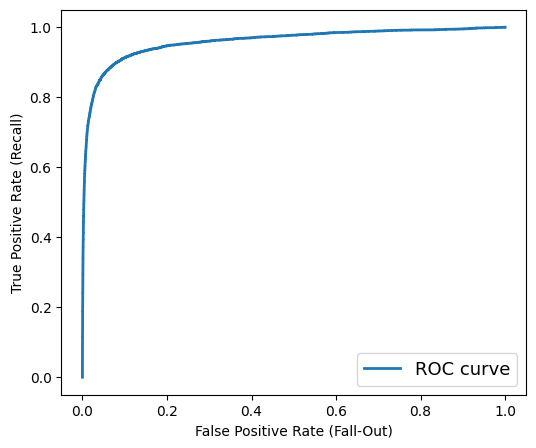

In [24]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.legend(loc="lower right", fontsize=13)
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')

In [25]:
# receiver-operator curve: 1 -> perfect classifier, 0.5 -> random classifier
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9595335878826209

In [26]:
# compare SGD to Random Forrest Classifier
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba") # use probabilites as scores -> for ROC curves

In [27]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(
    y_train_5, y_scores_forest)

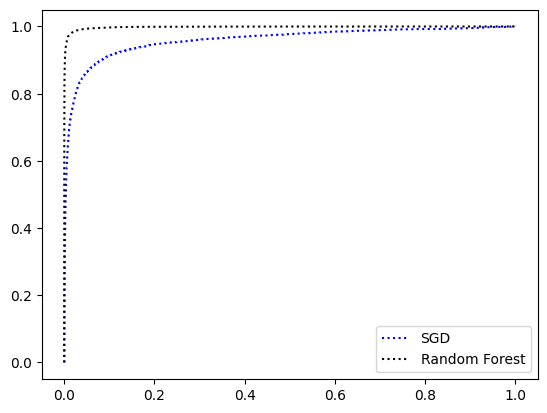

In [28]:
plt.plot(fpr, tpr, "b:", label='SGD')
plt.plot(fpr_forest, tpr_forest, "k:", label="Random Forest")
plt.legend(loc="lower right")

In [29]:
roc_auc_score(y_train_5, y_scores_forest)

0.9982652796366428

## Multiclass

In [30]:
# implicit one vs. all
sgd_bin.fit(X_train, y_train)
sgd_bin.predict([X_train[0]])

array(['4'], dtype='<U1')

In [32]:
sgd_bin.decision_function([X_train[0]])

array([[-20801.25903851, -32553.8445341 ,  -6880.24344731,
        -15647.7187226 ,   4755.94374836,  -5510.17349679,
         -8365.74052039,  -9504.04189856,  -7222.52733967,
         -9759.83336728]])

In [33]:
sgd_bin.classes_ # list of target classes for multiclassification

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U1')

In [34]:
# force OneVsOne
from sklearn.multiclass import OneVsOneClassifier

ovo_sgd = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_sgd.fit(X_train, y_train)
ovo_sgd.predict([X_train[0]])

array(['4'], dtype=object)

In [35]:
len(ovo_sgd.estimators_) # number of estimators: N*(N-1)/2 = 10*9/2 = 45

45

In [37]:
# random forest: just one needed
forest_clf.fit(X_train, y_train)
forest_clf.predict(X_train[:10])

array(['4', '4', '5', '1', '4', '6', '6', '8', '7', '9'], dtype=object)

In [38]:
forest_clf.predict_proba([X_train[0]])

array([[0.  , 0.  , 0.  , 0.01, 0.99, 0.  , 0.  , 0.  , 0.  , 0.  ]])

In [39]:
cross_val_score(sgd_bin, X_train, y_train, cv=3, scoring="accuracy")

array([0.866  , 0.88305, 0.8701 ])

In [40]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_bin, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.905  , 0.89995, 0.895  ])

# Error Analysis

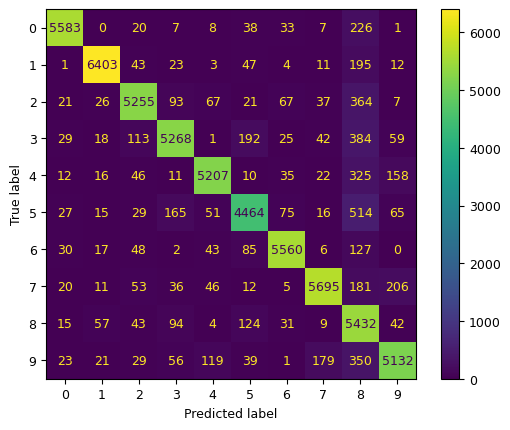

In [41]:
y_train_pred = cross_val_predict(sgd_bin, X_train_scaled, y_train, cv=3)
plt.rc('font', size=9)  # make the text smaller
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred) # for analysis which type of errors a model makes
plt.show()

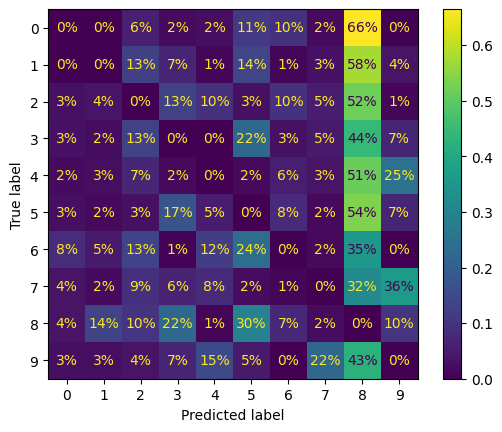

In [42]:
sample_weight = (y_train_pred != y_train)
plt.rc('font', size=10)  # extra code
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%") # normalize and exclude true predicted labels from calculation
plt.show()

# Multilabel Classification
Multiple labels possible for single sample.

In [43]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [44]:
knn_clf.predict([X_train[0]])

array([[False, False]])

In [45]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro") # evaluation metric dependant on project, here average of f1 for each label

0.9770578032525423

# Multioutput Classification
Multiple labels with multiple possible values for one single sample.

In [46]:
# add noise to images
np.random.seed(42)  # to make this code example reproducible
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

# Excercises

## MNIST CLassifier with min. 97% Accuracy on Test Set

In [49]:
from sklearn.model_selection import GridSearchCV

params = {'n_neighbors': [1, 3, 5, 8, 10, 15], 'weights': ['uniform', 'distance'], 'metric': ['minkowski', 'cosine', 'euclidean']}
cv_knn = GridSearchCV(knn_clf, params, scoring='accuracy', cv=3)
cv_knn.fit(X_train[:5000], y_train[:5000]) # reduce training time

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['minkowski', 'cosine', 'euclidean'],
                         'n_neighbors': [1, 3, 5, 8, 10, 15],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [ ]:
import pandas as pd
pd.DataFrame(cv_knn.cv_results_).sort_values(by='test_rank_score').head()

In [50]:
cv_knn.fit(X_train, y_train) # retrain on whole dataset
cv_knn.score(X_test, y_test)

## Image Shifting

In [ ]:
from scipy.ndimage import shift

In [ ]:
shifts = [[1, 0], [0, 1], [-1, 0], [0, -1]]
X_train_augmented = X_train.to_list()
y_train_augmented = y_train.to_list()

for x, y in zip(X_train, y_train):
    augmented_images = [shift(x, shift_curr) for shift_curr in shifts]
    X_train_augmented += augmented_images
    y_train_augmented += 4*y

shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented, y_train_augmented = np.array(X_train_augmented)[shuffle_idx], np.array(y_train_augmented)[shuffle_idx]

In [ ]:
knn_best = KNeighborsClassifier(cv_knn.best_params_)
knn_best.fit(X_train_augmented, y_train_augmented)
knn_best.score(X_test, y_test)

## Titanic Dataset
Reference: https://github.com/supraano/KaggleTitanic

# Spam Classifier
To be continued...